# CS4487 Project: Image classification

## Regarding course project
* External training data is not allowed. Learning can only be performed on the 50,000 training images in **CIFAR10**
* The [**CIFAR10** dataset](https://www.cs.toronto.edu/~kriz/cifar.html) was comprised of 60,000 32 × 32 color photographs of objects from 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.
* Submit the results at [Kaggle CS4487 Course Project](https://www.kaggle.com/c/cs4487cp/)
* The second test set containing roughly 2,000 images (refer to test_data/y_test.npy)

## Evaluation Criteria 

* ### Classification Accuaracy:
  ### $$ Acc(f, D) = \frac{1}{m}\sum_{i=1}^{m}\mathbb{I}[y^i = f(x^i)]$$

* ### File Format:
Upload a file in CSV format, such as:

|         **Index**         |         **Category**        |
|---------------------------|-----------------------------|
| 0                         | 8                           |
| 1                         | 4                           |
| 2                         | 6                           |
| 3                         | 1                           |
| ......                    | ......                      |
| 11999                     | 2                           |

PyTorch Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Import library

In [1]:
import numpy as np
from numpy import *
import cv2
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
import time
from _datetime import datetime

import torch
import torchvision
from torch.utils import data
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from progressbar import *

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
def print_time_and_msg(msg: str) -> str:
    now_time = time.time()
    readable_time = datetime.fromtimestamp(now_time).strftime(f'[%H:%M:%S:%m] - {msg}')
    print(readable_time)

### Progress Bar

In [5]:
def progress_bar(max_val: int):
    bar = ProgressBar(
        widgets=[
            'Progress: ',
            Percentage(), ' ', 
            Bar('#'), ' ', 
            Timer(), ' ', 
            ETA(), ' '
        ], 
        max_value=max_val
    )
    return bar


## Read images

### Read CIFAR10 data
* The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle.
* Loaded in this way, each of the batch files contains a dictionary with the following elements:
  * **data**: 
    * a 10,000 x 3,072 numpy array of uint8s. Each row of the array stores a 32 x 32 colour image. 
    * The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. 
    * The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
  * **labels**: 
    * a list of 10,000 numbers in the range 0 - 9. 
    * The number at index i indicates the label of the ith image in the array data.
* The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:
  * **label_names** -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. 
  * For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

In [6]:
def unpickle_cifar10(file: str) -> dict:
    full_name = f"./data/cifar-10-batches-py/{file}"
    
    with open(full_name, 'rb') as fi:
        cifar10_dict = pickle.load(fi, encoding='bytes')
    return cifar10_dict

In [7]:
cifar_meta = unpickle_cifar10("batches.meta")
cifar_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

10000

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

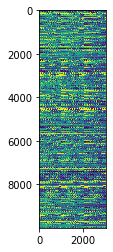

In [9]:
data_batch_1 = unpickle_cifar10("data_batch_1")
len(data_batch_1[b'labels'])
data_batch_1[b'data']
plt.imshow(data_batch_1[b'data'])

## A Basic Image Classifier

### Loading and normalizing CIFAR10 to dataloader

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [11]:
trainset = torchvision.datasets.CIFAR10(root='./data', download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=8, 
                                           shuffle=True, 
                                           num_workers=8, 
                                           pin_memory=True
                                          )

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, 
                                          batch_size=8,
                                          shuffle=False, 
                                          num_workers=8,
                                          pin_memory=True
                                         )

In [12]:
train_len = len(train_loader)
train_len
test_len = len(test_loader)
test_len

6250

1250

### Combine two data loader

### Show some of the training images, for fun

In [13]:
category_dict = {
    'airplane': 1, 
    'automobile': 2, 
    'bird': 3, 
    'cat': 4, 
    'deer': 5, 
    'dog': 6, 
    'frog': 7, 
    'horse': 8, 
    'ship': 9, 
    'truck': 10
}

In [14]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([8, 3, 32, 32])

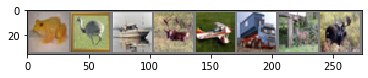

 frog  bird  ship  deer airplane truck  deer  deer


In [15]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % list(category_dict)[labels[j]] for j in range(len(images))))

### Define a Convolutional Neural Network

In [16]:
# argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d – they need to be the same number

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
#         print(f"In Model: input size, {x.size()} - output size - {x.size()}")
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Define a Loss function and optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [ ]:
epoch_num = 30

print_time_and_msg(f"Preparing data for {epoch_num} epoches")

final_loss = 0.0

for epoch in range(epoch_num):  # loop over the dataset multiple times
    
    running_loss = 0.0
    
    print_time_and_msg(f"Start training for the {epoch + 1} epoch...")
    train_bar = progress_bar(train_len)
    
    for i, data in enumerate(train_loader, 0):
        train_bar.update(i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print_time_and_msg(f'[{epoch + 1}, {i + 1}] loss: {round(running_loss / 2000, 3)}')
#             running_loss = 0.0
        final_loss = round(running_loss / train_len, 3)
    print_time_and_msg(f"Trained {epoch + 1} epoch, the loss is {final_loss}")

print_time_and_msg(f'Finished training total {train_len} data for {epoch_num} epoches,\nthe final loss is {final_loss}')


[20:09:03:12] - Preparing data for 30 epoches
[20:09:03:12] - Start training for the 1 epoch...


Progress:  57% |#############           | Elapsed Time: 0:00:33 ETA:   0:00:23 

### Save the trained model

In [ ]:
PATH_basic = './basic_cifar_net.pth'

In [ ]:
torch.save(net.state_dict(), PATH_basic)

### Jump to [project test data](#Run-the-model-in-test-data)

### Test the network

#### Display some images of test data

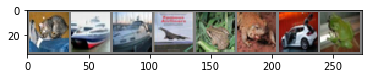

GroundTruth:    cat  ship  ship airplane  frog  frog automobile  frog


In [19]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % list(category_dict)[labels[j]] for j in range(len(images))))

#### Load the saved model

In [18]:
net = Net()
# net.to(device)
net.load_state_dict(torch.load(PATH_basic))

<All keys matched successfully>

#### Test the network using the model

In [98]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % list(category_dict)[predicted[j]]
                              for j in range(len(images))))

tensor([4, 6, 5, 3, 5, 8, 2, 4])
Predicted:   deer  frog   dog   cat   dog  ship  bird  deer


#### Test in the whole dataset

In [19]:
test_bar = progress_bar(test_len)

In [ ]:
correct = 0
total = 0
p = 0
with torch.no_grad():
    for ti, data in enumerate(test_loader):
        
        images, labels = data#[0].to(device), data[1].to(device)
        images.shape
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        test_bar.update(ti)

print(f'Accuracy of the network on the {len(test_loader)} test images: {100 * correct / total}%')

#### Show the accuracy of each category

In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data#[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print(f'Accuracy of {list(category_dict)[i]} : {round(100 * class_correct[i] / class_total[i], 2)}%')

Accuracy of airplane : 64.9%
Accuracy of automobile : 66.12%
Accuracy of bird : 44.3%
Accuracy of cat : 30.95%
Accuracy of deer : 52.94%
Accuracy of dog : 52.42%
Accuracy of frog : 69.02%
Accuracy of horse : 55.95%
Accuracy of ship : 70.37%
Accuracy of truck : 64.24%


## Run the model in test data 

### Load test data

In [ ]:
project_testset = np.load("./data/test_data/y_test.npy").astype(np.uint8)
project_testset = np.moveaxis(project_testset, -1, 1)
project_testset.shape
type(project_testset)

### Convert to DataLoader ([Convertion Reference](https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader))

In [ ]:
from torch.utils import data
tensor_testset = torch.Tensor(project_testset)
the_dataset = data.TensorDataset(tensor_testset)
project_test_loader = data.DataLoader(the_dataset, 
                                      batch_size=len(project_testset),
                                      num_workers=8,
                                      pin_memory=True
                                     )

### Run the test

In [ ]:
test_net = Net()
# net.to(device)
test_net.load_state_dict(torch.load(PATH_basic))

In [ ]:
predict_result = []

with torch.no_grad():
    for index, imgs in enumerate(project_test_loader):
        imgs = torch.stack([torch.Tensor(i) for i in imgs]).squeeze()
        outputs = test_net(imgs)
        _, predicted = torch.max(outputs.data, 1)
        
        predict_result = predicted

len(predict_result)

### Save to csv file

In [ ]:
result_df = pd.DataFrame(
    list(predict_result),
    columns=["Category"]
)
result_df.index.name = "Index"
# result_df

In [ ]:
result_df.to_csv("predict_result.csv")